In [1]:
# %%
import os
import sys

from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
# %%
import functools
import os
import distrax


import jax
import jax.numpy as jnp
from jax import random
from typing import Tuple, Dict, Any
from dataclasses import dataclass
import chex
from flax import struct
from absl import app, flags
from ml_collections import config_flags
from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
import matplotlib.pyplot as plt
from impls.utils.networks import GCDiscreteActor
import copy
import numpy as np
import IPython.display as display




In [2]:
def display_gif(env, timesteps, idx):
    grid_size = timesteps.grid.shape[-2:]
    fig, ax = plt.subplots(figsize=grid_size)

    animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x[:,idx:].swapaxes(1, 0), timesteps), img_prefix=os.path.join(ROOT_DIR, 'assets'))

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)

    # Save as GIF
    gif_path = f"/tmp/block_moving_epoch.gif"
    anim.save(gif_path, writer='pillow')
    plt.close()


    # Visualize the GIF in the notebook
    display.display(display.Image(filename=gif_path))

def plot_q_value_difference(agent, states, goals, actions, episode_length, num_envs):
    """
    Plot the absolute difference between Q1 and Q2 values over timesteps.
    
    Parameters:
    -----------
    agent : Agent
        The agent with the critic network
    states : Array
        Trajectory states with shape (episode_length, num_envs, ...)
    goals : Array
        Trajectory goals with shape (episode_length, num_envs, ...)
    actions : Array
        Trajectory actions with shape (episode_length, num_envs)
    episode_length : int
        Length of episodes
    num_envs : int
        Number of parallel environments
    """
    # Reshape trajectories to combine episode and environment dimensions
    traj_states_flat = states.reshape((states.shape[0] * states.shape[1], -1))
    traj_goals_flat = goals.reshape((goals.shape[0] * goals.shape[1], -1))
    traj_actions_flat = actions.reshape((actions.shape[0] * actions.shape[1]))
    
    # Get Q-values from critic network
    q1, q2 = agent.network.select('critic')(traj_states_flat, traj_goals_flat, traj_actions_flat)
    
    # Reshape back to (episode_length, num_envs)
    q1 = q1.reshape((episode_length, num_envs))
    q2 = q2.reshape((episode_length, num_envs))
    
    # Compute mean and standard error of absolute difference
    q_diff = jnp.mean(jnp.abs(q1 - q2), axis=1)
    q_diff_std_error = jnp.std(jnp.abs(q1 - q2), axis=1) / jnp.sqrt(q1.shape[1])
    
    # Plot
    plt.plot(q_diff, label='|q1 - q2|')
    plt.fill_between(np.arange(len(q_diff)), q_diff - q_diff_std_error, 
                     q_diff + q_diff_std_error, alpha=0.2)
    plt.xlabel('Timestep')
    plt.ylabel('Absolute Difference')
    plt.title('Distance between q1 and q2 over Timesteps')
    plt.legend()
    plt.show()


In [3]:
# %%
RANGE_GENERALIZATION = [1,2,3,4,5,6,7,9,11]
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 40
RUN_NAME = f"DQN{CHECKPOINT}_investigation"
MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20251018_180741/runs/dqn_additional_loss_simple_te-1.38_3_grid_4_ep_len__filter_"
# MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20251016_222226/runs/dqn_1.38_bilinear_2_grid_4" #for bilinear remember to change critic_def in dqn.py
# MODEL_PATH = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_4_grid_4_ep_len__filter_"
EPOCHS = 51
EVAL_EVERY = 10
FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"
GIF_PATH = f"{FIGURES_PATH}/gifs"
os.makedirs(FIGURES_PATH, exist_ok=True)
# os.makedirs(GIF_PATH, exist_ok=True)


In [4]:
# %%
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=4,
        number_of_boxes_min=1,
        number_of_boxes_max=1,
        number_of_moving_boxes_max=1
    )
)

# %%
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
partial_flatten = functools.partial(flatten_batch, get_next_obs=config.agent.use_next_obs)
jitted_flatten_batch = jax.jit(jax.vmap(partial_flatten, in_axes=(None, 0, 0)), static_argnums=(0,))
dummy_timestep = env.get_dummy_timestep(key)


In [5]:
replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.agent.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)

example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),  # Add batch dimension
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8)
    * (env._env.action_space - 1),  # it should be the maximal value of action space
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

# %%
agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)


Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20251018_180741/runs/dqn_additional_loss_simple_te-1.38_3_grid_4_ep_len__filter_/params_40.pkl


In [6]:
# Create env once again with correct config and collect data
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)


# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

2025-10-18 19:00:39.826940: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [7]:
timesteps.__dict__.keys()

dict_keys(['key', 'grid', 'agent_pos', 'agent_has_box', 'steps', 'number_of_boxes', 'goal', 'reward', 'success', 'extras', 'action', 'done', 'truncated'])

In [8]:
jax.numpy.save("/home/mbortkie/repos/crl_subgoal/notebooks/timesteps", timesteps.grid)

In [9]:
import numpy as np
grid_timesteps = np.load("/home/mbortkie/repos/crl_subgoal/notebooks/timesteps.npy")
grid_timesteps.shape

(100, 1024, 4, 4)

In [10]:
grid_timesteps[0,0]

array([[1, 0, 0, 2],
       [2, 0, 0, 0],
       [3, 1, 0, 0],
       [0, 0, 1, 2]], dtype=int8)

In [11]:
jitted_flatten_batch = jax.jit(jax.vmap(flatten_batch, in_axes=(None, None, 0, 0)), static_argnums=(0, 1))
jitted_create_batch = functools.partial(
    create_batch,
    gamma=config.exp.gamma,
    # use_targets=config.exp.use_targets,
    use_targets=True,
    use_future_and_random_goals=config.exp.use_future_and_random_goals,
    jitted_flatten_batch=jitted_flatten_batch,
    use_discounted_mc_rewards=config.agent.use_discounted_mc_rewards,
)

In [12]:
batch_key = random.PRNGKey(0)
buffer_state, transitions = replay_buffer.sample(buffer_state)
batch = jitted_create_batch(transitions, batch_key)

In [13]:
batch.keys()

dict_keys(['observations', 'next_observations', 'actions', 'rewards', 'masks', 'value_goals', 'actor_goals'])

In [14]:
batch['observations'].shape

(256, 16)

In [15]:
all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['value_goals'], all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6


2025-10-18 19:00:50.708528: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [16]:
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
dist.probs.shape

(256, 6)

(array([  1.,   0.,   0.,   3.,   1.,   3.,   8.,  22.,  77., 141.]),
 array([1.41041911, 1.4479723 , 1.48552561, 1.52307892, 1.56063211,
        1.5981853 , 1.63573861, 1.67329192, 1.71084511, 1.7483983 ,
        1.78595161]),
 <BarContainer object of 10 artists>)

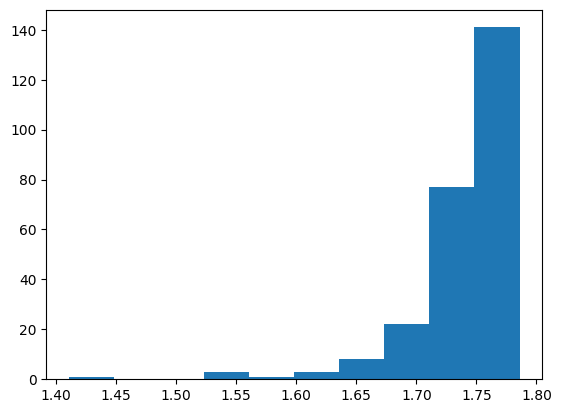

In [17]:
plt.hist(dist.entropy())

In [18]:
use_targets = False

timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=remove_targets(timesteps.grid),
        goal=remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

In [19]:
tr_states.shape

(100, 1024, 4, 4)

In [20]:
idx = 0
traj_states, traj_goals, traj_actions = tr_states[:,idx], tr_goals[:,idx], tr_actions[:,idx]
traj_states.shape

(100, 4, 4)

In [21]:
traj_states, traj_goals, traj_actions = traj_states.reshape(traj_states.shape[0], -1), traj_goals.reshape(traj_goals.shape[0], -1), traj_actions.reshape(traj_actions.shape[0])
traj_states.shape

(100, 16)

# Check symmetry
Whether Q(s0,a0,g=s1)>=Q(s0,a0,g=s2)>=Q(s0,a0,g=sT)

In [22]:
# 
idx = 35
traj_states, traj_goals, traj_actions = tr_states[:,idx], tr_goals[:,idx], tr_actions[:,idx]
traj_states, traj_goals, traj_actions = traj_states.reshape(traj_states.shape[0], -1), traj_goals.reshape(traj_goals.shape[0], -1), traj_actions.reshape(traj_actions.shape[0])

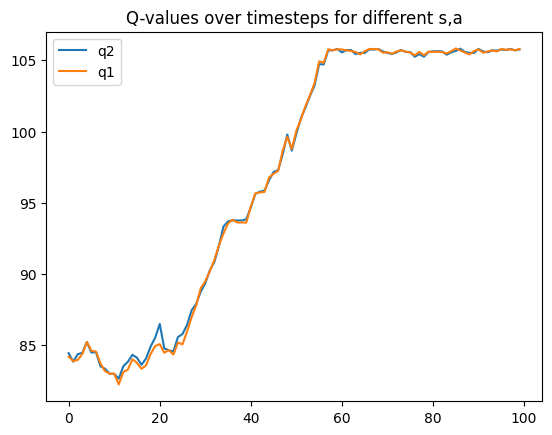

In [41]:
q1, q2 = agent.network.select('critic')(traj_states, traj_goals, traj_actions)

plt.title("Q-values over timesteps for different s,a")
plt.plot(q2, label='q2')
plt.plot(q1, label='q1')
plt.legend()
plt.show()

In [42]:
traj_states.shape

(100, 16)

In [43]:
traj_states_only_s0 = jnp.expand_dims(traj_states[0,:], axis=0)
traj_actions_only_s0 = jnp.expand_dims(traj_actions[0], axis=0)
traj_states_only_s0.shape, traj_actions_only_s0.shape


((1, 16), (1,))

In [44]:
traj_states_only_s0 = jnp.concatenate([traj_states_only_s0 for _ in range(traj_states.shape[0])], axis=0)
traj_actions_only_s0 = jnp.concatenate([traj_actions_only_s0 for _ in range(traj_states.shape[0])], axis=0)
traj_states_only_s0.shape, traj_actions_only_s0.shape

((100, 16), (100,))

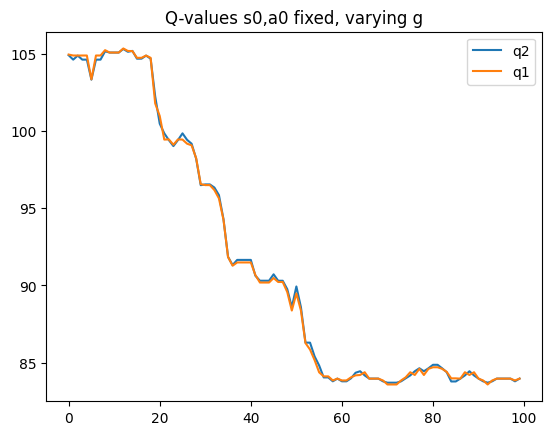

In [45]:
q1, q2 = agent.network.select('critic')(traj_states_only_s0, traj_states, traj_actions_only_s0)

plt.title("Q-values s0,a0 fixed, varying g")
plt.plot(q2, label='q2')
plt.plot(q1, label='q1')
plt.legend()
plt.show()

In [28]:
x=1
traj_states_only_sx = jnp.expand_dims(traj_states[x,:], axis=0)
traj_actions_only_sx = jnp.expand_dims(traj_actions[x], axis=0)
traj_states_only_sx = jnp.concatenate([traj_states_only_sx for _ in range(traj_states.shape[0])], axis=0)
traj_actions_only_sx = jnp.concatenate([traj_actions_only_sx for _ in range(traj_states.shape[0])], axis=0)
q1, q2 = agent.network.select('critic')(traj_states_only_s0, traj_states, traj_actions_only_s0)
q_mean = (q1 + q2) / 2


In [29]:
q_mean

Array([104.94394 , 104.77008 , 104.89955 , 104.77008 , 104.77008 ,
       103.34879 , 104.77008 , 104.77008 , 105.21251 , 105.09546 ,
       105.09546 , 105.09546 , 105.34346 , 105.17189 , 105.19644 ,
       104.72627 , 104.72627 , 104.89955 , 104.72627 , 102.02808 ,
       100.73393 ,  99.65721 ,  99.4451  ,  99.0767  ,  99.4451  ,
        99.65721 ,  99.31409 ,  99.13431 ,  98.227234,  96.53479 ,
        96.52779 ,  96.52779 ,  96.26581 ,  95.74814 ,  94.27425 ,
        91.84949 ,  91.30072 ,  91.57555 ,  91.57555 ,  91.57555 ,
        91.57555 ,  90.6544  ,  90.24986 ,  90.24986 ,  90.24986 ,
        90.60424 ,  90.26699 ,  90.26699 ,  89.66817 ,  88.48406 ,
        89.71199 ,  88.48406 ,  86.283264,  86.07094 ,  85.28618 ,
        84.594055,  84.07711 ,  84.07711 ,  83.819046,  83.96493 ,
        83.819046,  83.819046,  84.01726 ,  84.26097 ,  84.32156 ,
        84.27522 ,  83.96493 ,  83.96493 ,  83.96493 ,  83.819046,
        83.64299 ,  83.64299 ,  83.64299 ,  83.819046,  84.017

In [30]:
q_s = []
for x in range(100):
    traj_states_only_sx = jnp.expand_dims(traj_states[x,:], axis=0)
    traj_actions_only_sx = jnp.expand_dims(traj_actions[x], axis=0)
    traj_states_only_sx = jnp.concatenate([traj_states_only_sx for _ in range(traj_states.shape[0])], axis=0)
    traj_actions_only_sx = jnp.concatenate([traj_actions_only_sx for _ in range(traj_states.shape[0])], axis=0)
    q1, q2 = agent.network.select('critic')(traj_states_only_sx, traj_states, traj_actions_only_sx)
    q_mean = (q1 + q2) / 2
    q_s.append(q_mean)
q_s= jnp.array(q_s)

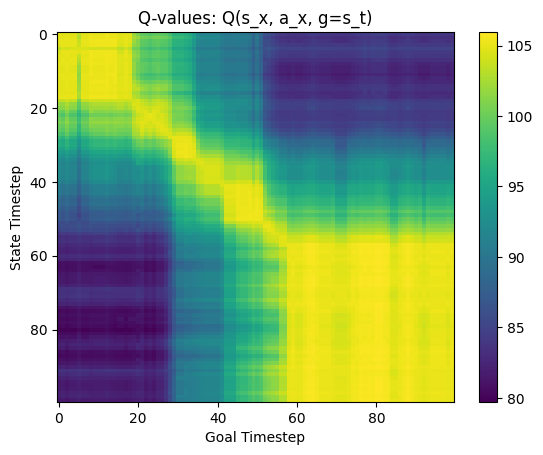

In [32]:
plt.imshow(q_s[:100,:100], aspect='auto', cmap='viridis')
plt.colorbar()
plt.xlabel('Goal Timestep')
plt.ylabel('State Timestep')
plt.title('Q-values: Q(s_x, a_x, g=s_t)')
plt.show()

rows - q(s,a,gi) for different goals
columns - q(si,ai, g) for different (s,a) pairs

In [33]:
q_s[0] # goals are increasing s_t, while state and action is s_0, a_0

Array([104.94394 , 104.77008 , 104.89955 , 104.77008 , 104.77008 ,
       103.34879 , 104.77008 , 104.77008 , 105.21251 , 105.09546 ,
       105.09546 , 105.09546 , 105.34346 , 105.17189 , 105.19644 ,
       104.72627 , 104.72627 , 104.89955 , 104.72627 , 102.02808 ,
       100.73393 ,  99.65721 ,  99.4451  ,  99.0767  ,  99.4451  ,
        99.65721 ,  99.31409 ,  99.13431 ,  98.227234,  96.53479 ,
        96.52779 ,  96.52779 ,  96.26581 ,  95.74814 ,  94.27425 ,
        91.84949 ,  91.30072 ,  91.57555 ,  91.57555 ,  91.57555 ,
        91.57555 ,  90.6544  ,  90.24986 ,  90.24986 ,  90.24986 ,
        90.60424 ,  90.26699 ,  90.26699 ,  89.66817 ,  88.48406 ,
        89.71199 ,  88.48406 ,  86.283264,  86.07094 ,  85.28618 ,
        84.594055,  84.07711 ,  84.07711 ,  83.819046,  83.96493 ,
        83.819046,  83.819046,  84.01726 ,  84.26097 ,  84.32156 ,
        84.27522 ,  83.96493 ,  83.96493 ,  83.96493 ,  83.819046,
        83.64299 ,  83.64299 ,  83.64299 ,  83.819046,  84.017

In [34]:
q_s[:,-1] # states are increasing s_t, while goal is the last state s_99

Array([ 83.96493 ,  83.321815,  83.71483 ,  84.13489 ,  84.95551 ,
        84.22539 ,  83.975716,  83.38252 ,  82.77428 ,  82.4348  ,
        82.4348  ,  82.08859 ,  82.743095,  82.744736,  83.47446 ,
        83.60473 ,  82.93758 ,  83.24153 ,  84.199905,  84.704346,
        84.68489 ,  84.18507 ,  84.25859 ,  84.26925 ,  84.9574  ,
        84.90037 ,  85.63898 ,  86.623764,  87.52177 ,  88.82689 ,
        88.943146,  89.69876 ,  90.67421 ,  91.309395,  92.15202 ,
        92.612816,  92.80124 ,  92.567825,  92.567825,  92.54603 ,
        93.79015 ,  94.81825 ,  94.97749 ,  95.05381 ,  95.85951 ,
        96.54336 ,  96.73849 ,  97.85214 ,  98.91774 ,  97.8797  ,
        99.06281 ,  99.844376, 100.76726 , 101.706955, 102.91834 ,
       103.76935 , 104.28459 , 105.18848 , 105.21103 , 105.25253 ,
       105.11181 , 105.22809 , 105.24577 , 105.033585, 105.25476 ,
       105.258965, 105.17066 , 105.17066 , 105.25253 , 105.09761 ,
       104.95508 , 104.93463 , 105.1951  , 105.22809 , 105.112

# Old

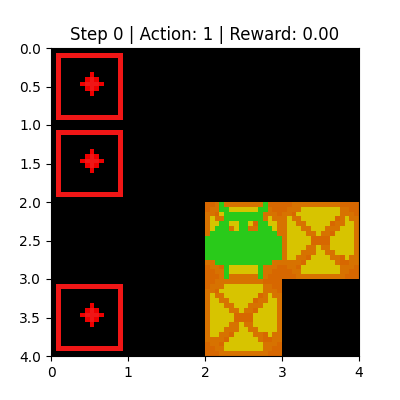

In [35]:
display_gif(env, timesteps, idx)

## Modified

In [ ]:
idx = 0
traj_states, traj_goals, traj_actions = tr_states[:,idx], tr_goals[:,idx], tr_actions[:,idx]
traj_states.shape

(100, 4, 4)

In [ ]:
traj_states, traj_goals, traj_actions = traj_states.reshape(traj_states.shape[0], -1), traj_goals.reshape(traj_goals.shape[0], -1), traj_actions.reshape(traj_actions.shape[0])
traj_states.shape

(100, 16)

2025-10-03 21:41:42.096377: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


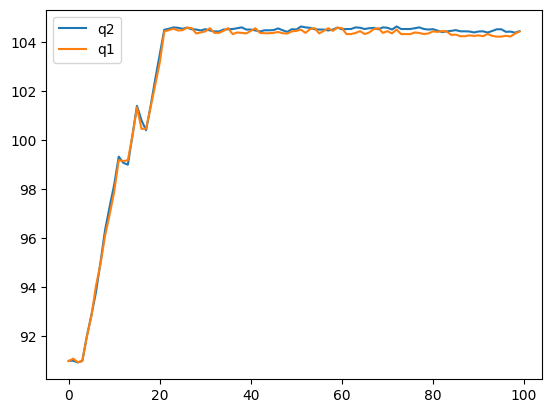

In [ ]:
q1, q2 = agent.network.select('critic')(traj_states, traj_goals, traj_actions)

plt.plot(q2, label='q2')
plt.plot(q1, label='q1')
plt.legend()
plt.show()

# Old

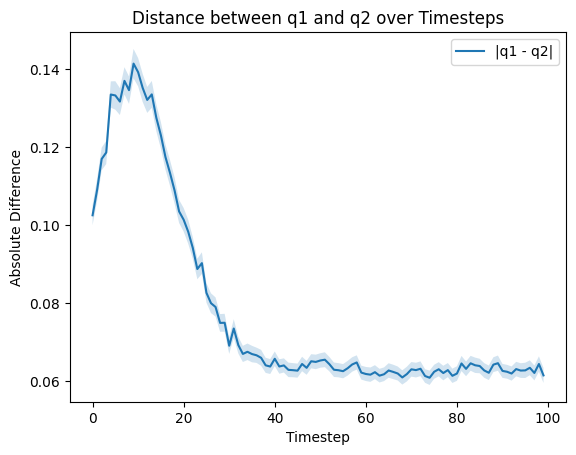

In [35]:
# Use the function
plot_q_value_difference(agent, tr_states, tr_goals, tr_actions, EPISODE_LENGTH, NUM_ENVS)

# Diagonal setup

In [19]:
config.env.generator_special=True

In [20]:
# Create env once again with correct config and collect data
env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))

# %%
keys = random.split(random.PRNGKey(0), NUM_ENVS)
state, info = env.reset(keys)

# %%
dummy_timestep = env.get_dummy_timestep(key)

replay_buffer = jit_wrap(
    TrajectoryUniformSamplingQueue(
        max_replay_size=config.exp.max_replay_size,
        dummy_data_sample=dummy_timestep,
        sample_batch_size=config.exp.batch_size,
        num_envs=config.exp.num_envs,
        episode_length=config.env.episode_length,
    )
)
buffer_state = jax.jit(replay_buffer.init)(key)


# %%
data_key = random.PRNGKey(0)
_, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
buffer_state = replay_buffer.insert(buffer_state, timesteps)

In [21]:
jitted_flatten_batch = jax.jit(jax.vmap(flatten_batch, in_axes=(None, None, 0, 0)), static_argnums=(0, 1))
jitted_create_batch = functools.partial(
    create_batch,
    gamma=config.exp.gamma,
    use_targets=config.exp.use_targets,
    use_future_and_random_goals=config.exp.use_future_and_random_goals,
    jitted_flatten_batch=jitted_flatten_batch,
    use_discounted_mc_rewards=config.agent.use_discounted_mc_rewards,
)

In [22]:
batch_key = random.PRNGKey(0)
buffer_state, transitions = replay_buffer.sample(buffer_state)
batch = jitted_create_batch(transitions, batch_key)

In [23]:
batch.keys()

dict_keys(['observations', 'next_observations', 'actions', 'rewards', 'masks', 'value_goals', 'actor_goals'])

In [24]:
all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))  # B x 6
qs = jax.lax.stop_gradient(
    jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['value_goals'], all_actions)
)  # 6 x 2 x B
qs = qs.min(axis=1)  # 6 x B
qs = qs.transpose(1, 0)  # B x 6


In [25]:
dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
dist.probs.shape

(256, 6)

(array([ 2.,  0.,  2.,  6., 12., 19., 17., 43., 71., 84.]),
 array([0.93940353, 1.02462208, 1.10984075, 1.1950593 , 1.28027797,
        1.36549652, 1.45071507, 1.53593373, 1.62115228, 1.70637083,
        1.7915895 ]),
 <BarContainer object of 10 artists>)

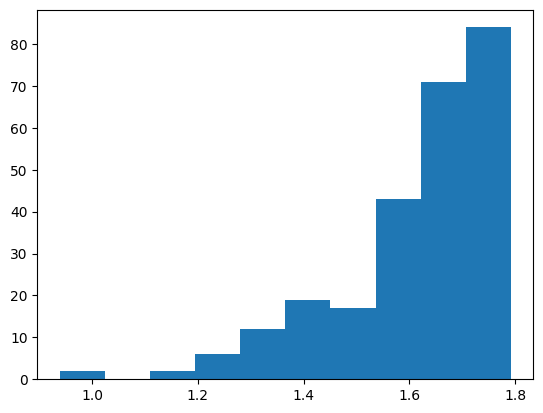

In [26]:
plt.hist(dist.entropy())

In [27]:
use_targets = False

timesteps_tr = jax.lax.cond(
    use_targets,
    lambda: timesteps.replace(),
    lambda: timesteps.replace(
        grid=remove_targets(timesteps.grid),
        goal=remove_targets(timesteps.goal)
    )
)

tr_states = timesteps_tr.grid
tr_actions = timesteps_tr.action
tr_goals = timesteps_tr.goal

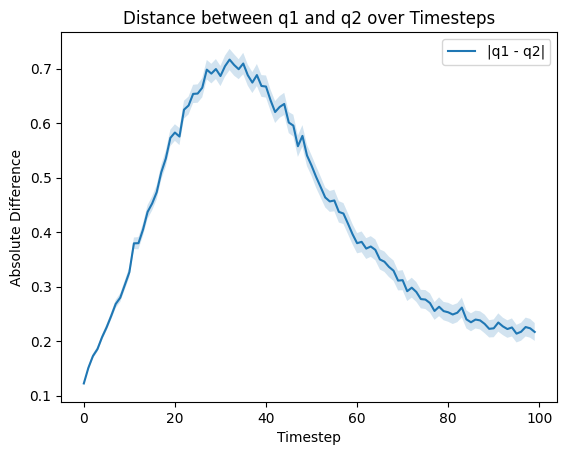

In [28]:
plot_q_value_difference(agent, tr_states, tr_goals, tr_actions, EPISODE_LENGTH, NUM_ENVS)

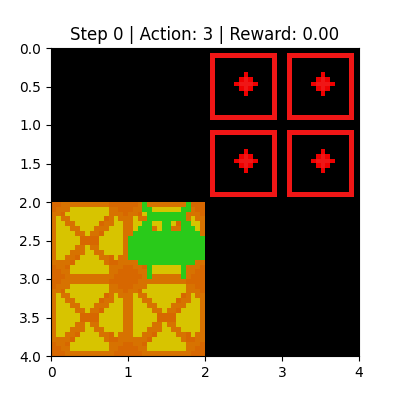

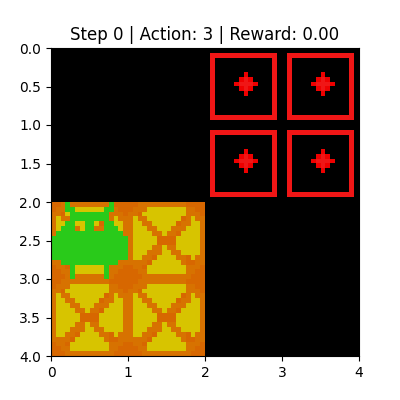

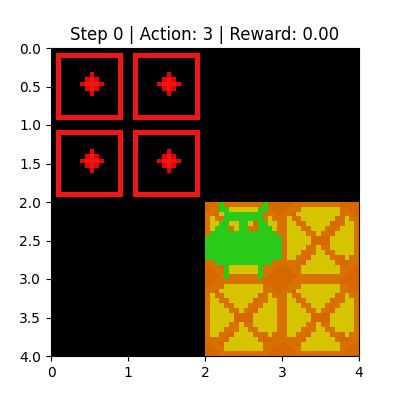

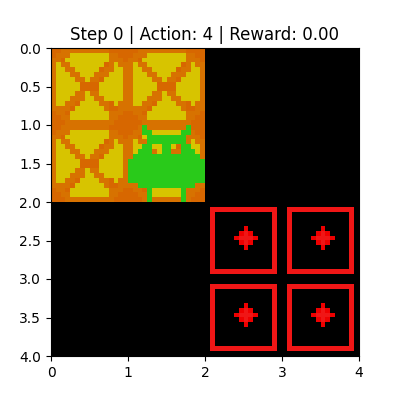

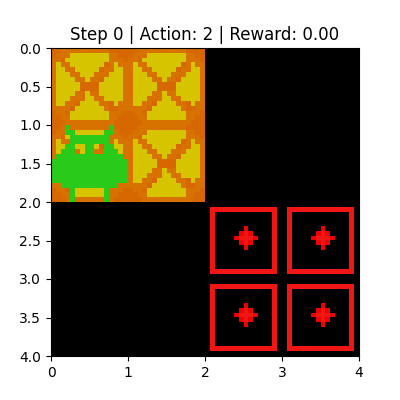

In [29]:
for idx in range(5):
    display_gif(env, timesteps, idx)


# S G different quadrants

In [47]:
import numpy as np

def gen_matrices(n, quarter=1, k=2, seed=None, shape=(6,6)):
    """
    Generate `n` random 6x6 matrices (dtype=int8).
    - `quarter` in {1,2,3,4} selects the 3x3 quadrant:
        1: top-left, 2: top-right, 3: bottom-left, 4: bottom-right
    - `k` is the number of ones to place (1..9) inside that 3x3 quarter (no duplicates).
    - Places a single 3 somewhere else (never on a cell that is 1).
    Returns array of shape (n, 6, 6), dtype=np.int8.
    """
    if quarter not in (1, 2, 3, 4):
        raise ValueError("quarter must be 1,2,3 or 4")
    if not (1 <= k <= shape[0]*shape[1]):
        raise ValueError(f"k must be between 1 and {shape[0]*shape[1]} (inclusive)")
    rng = np.random.default_rng(seed)
    qmap = {1: (0, 0), 2: (0, shape[1]//2), 3: (shape[0]//2, 0), 4: (shape[0]//2, shape[1]//2)}
    sr, sc = qmap[quarter]

    out = np.zeros((n, *shape), dtype=np.int8)
    for i in range(n):
        # choose k distinct positions inside the 3x3 quarter (index 0..8)
        sel = rng.choice(shape[0]*shape[1], size=k, replace=False)
        rows = sr + sel // (shape[0]//2)
        cols = sc + sel % (shape[1]//2)
        out[i, rows, cols] = 1

        # choose one location for the value 3 that is not already 1
        free_positions = np.flatnonzero(out[i].ravel() == 0)
        pos3 = rng.choice(free_positions)
        out[i].ravel()[pos3] = 3 # place agent

    return out


In [49]:
mats_q1 = gen_matrices(2, quarter=1, k=2, seed=43, shape=(4,4))  # returns shape (100,4,4)
mats_q2 = gen_matrices(100, quarter=2, k=2, seed=43, shape=(4,4))  # returns shape (100,4,4)
mats_q3 = gen_matrices(100, quarter=3, k=2, seed=43, shape=(4,4))  # returns shape (100,4,4)
mats_q4 = gen_matrices(100, quarter=4, k=2, seed=43, shape=(4,4))  # returns shape (100,4,4)
print(mats_q1[10],"\n", mats_q2[10], "\n", mats_q3[10], "\n", mats_q4[10])

IndexError: index 5 is out of bounds for axis 1 with size 4

In [38]:
mats_q1 = mats_q1.reshape(100, -1)
mats_q2 = mats_q2.reshape(100, -1)
mats_q3 = mats_q3.reshape(100, -1)
mats_q4 = mats_q4.reshape(100, -1)
mats_q1.shape

(100, 36)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20251016_222226/runs/dqn_1.38_bilinear_2_grid_4/params_0.pkl
mats_q1 - Checkpoint 0


ScopeParamShapeError: Initializer expected to generate shape (16, 256) but got shape (36, 256) instead for parameter "kernel" in "/modules_critic/vmap(psi)/Dense_0". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

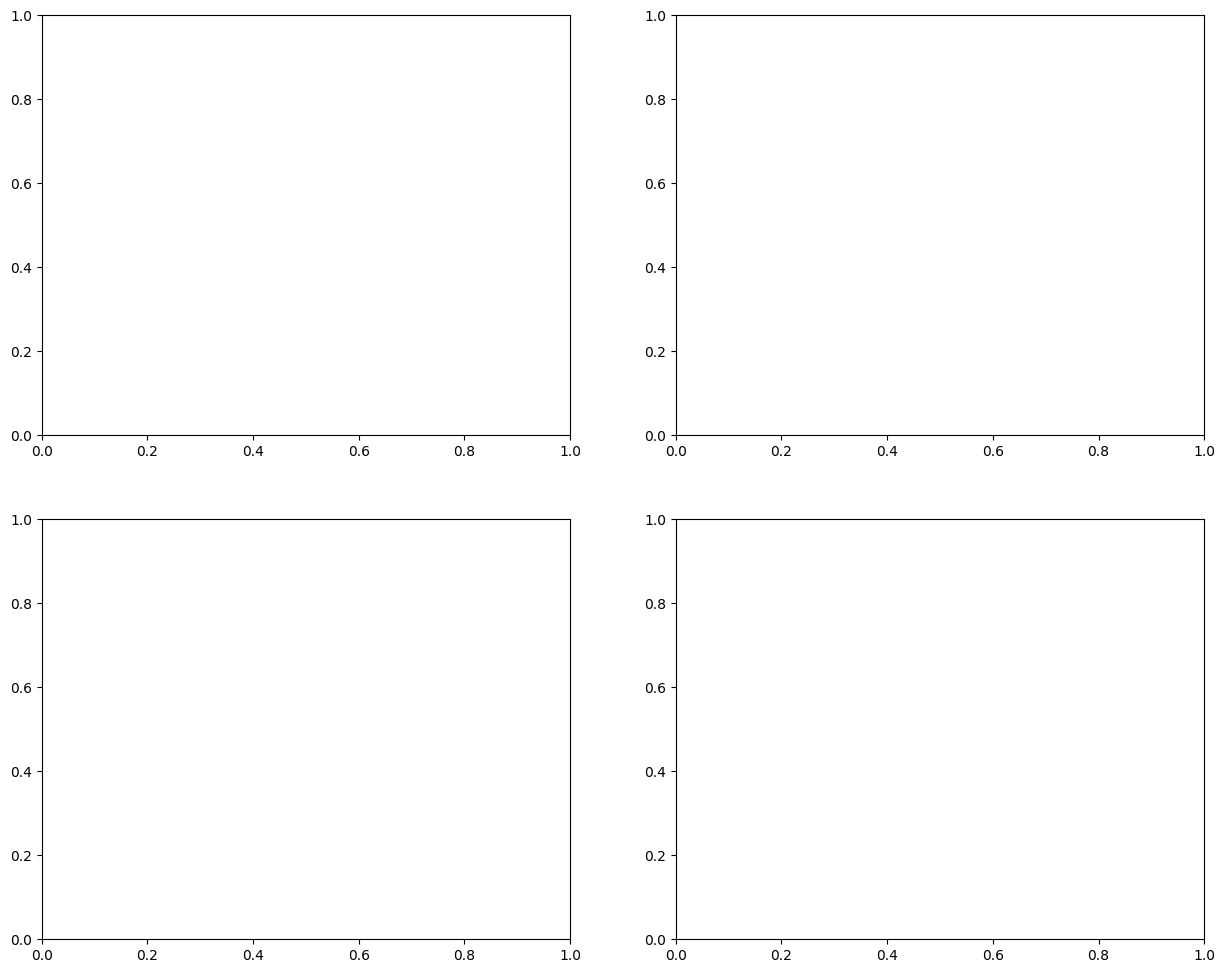

In [ ]:
# Collect data for plotting
checkpoints = range(0, EPOCHS, EVAL_EVERY)

# Create subplots for each matrix
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (base_mat_name, base_mat) in enumerate([("mats_q1", mats_q1), ("mats_q2", mats_q2), ("mats_q3", mats_q3), ("mats_q4", mats_q4)]):
    results = {mat_name: [] for mat_name in ["mats_q1", "mats_q2", "mats_q3", "mats_q4"]}
    
    for mat_name, mat in [("mats_q1", mats_q1), ("mats_q2", mats_q2), ("mats_q3", mats_q3), ("mats_q4", mats_q4)]:
        for checkpoint in checkpoints:
            agent, config = restore_agent(example_batch, MODEL_PATH, checkpoint)
            print(f"{base_mat_name} - Checkpoint {checkpoint}")
            
            q1, q2 = agent.network.select('critic')(base_mat, mat, traj_actions)
            log_mean = jnp.log(jnp.mean((q1+q2)/2))
            results[mat_name].append(log_mean)
            print(f"  {base_mat_name} to {mat_name}: q mean: {jnp.mean((q1+q2)/2):.2f}, log mean: {log_mean:.2f}")
        print()
    
    # Plot results for this base matrix
    ax = axes[idx]
    for mat_name in results.keys():
        ax.plot(list(checkpoints), results[mat_name], marker='o', label=mat_name)
    
    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Log Mean Q-value')
    ax.set_title(f'Log Mean Q-values from {base_mat_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()